# Housing Prices Prediction with Ensemble Regression

The three ensemble methods chosen for this project are Random Forest, Gradient Boosting, and Bagging. While all three methods aim to improve predictive accuracy through combining multiple models, they differ in their approach: 
* Random Forest constructs a collection of decision trees and averages their predictions, 
* Gradient Boosting builds an ensemble by sequentially improving upon the errors of previous models, and 
* Bagging generates multiple models using bootstrap samples to reduce variance.

Build a regression model to predict the bike rental demand based on various factors. Implement and compare the performance of different ensemble regression methods to improve the prediction accuracy.

## Imports

In [268]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Data

Load the Boston Housing dataset

In [269]:
boston = load_boston()
data = pd.DataFrame(boston.data, columns=boston.feature_names)
data['target'] = boston.target

In [270]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [271]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Create a heatmap of the correlation matrix. 

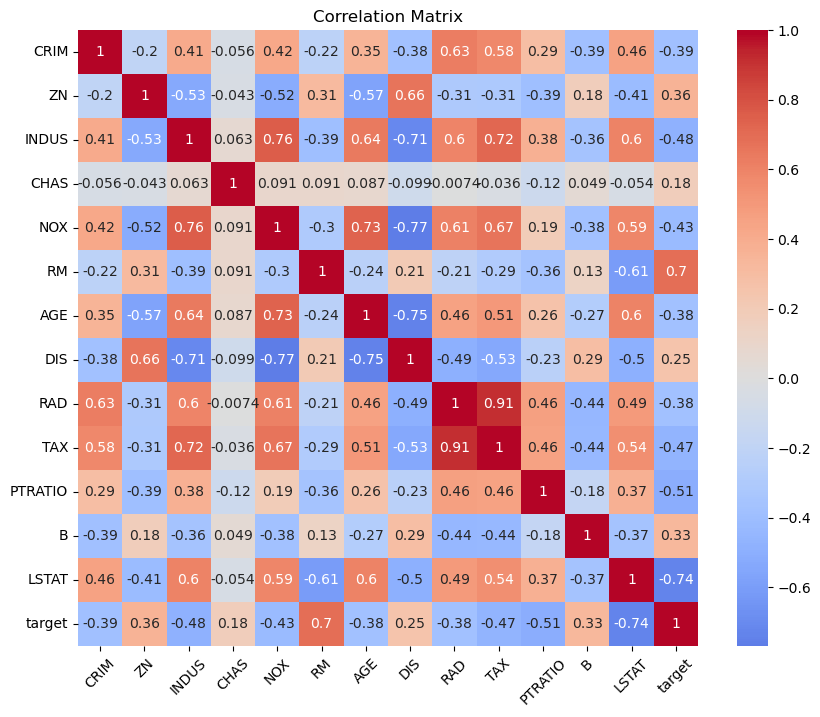

In [272]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Select relevant features and target variable. We see that the target is somewhat correlated to all features, so we decide to utilize them all for our regression. 

In [273]:
features = data.drop('target', axis=1)
target = 'target'

In [274]:
X = features
y = data[target]

Split the dataset into training and testing sets

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model

Create the ensemble models: Random Forest, Gradient Boosting, and Bagging

In [276]:
models = [
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42)),
    ("Bagging", BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=42), random_state=42))
]

### Hyperparameter Tuning

The ensemble methods have some hyperparameters we want to tune using grid search:

* Random Forest Parameters (RandomForestRegressor):
  * n_estimators: The number of trees in the forest.
  * max_depth: The maximum depth of the tree. If set to None, nodes are expanded until they contain less than min_samples_split samples.
* Gradient Boosting Parameters (GradientBoostingRegressor):
  * n_estimators: The number of boosting stages (trees) to be used in the ensemble.
  * learning_rate: The step size at which the boosting iteration shrinks the contribution of each tree.
* Bagging Parameters (BaggingRegressor):
  * n_estimators: The number of base estimators in the ensemble.
  * max_samples: The proportion of samples to draw from the training set for fitting each base estimator.

In [277]:
param_grids = [
    {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]},
    {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]},
    {"n_estimators": [50, 100, 200], "max_samples": [0.5, 0.7, 0.9]}
]

In [278]:
best_estimators = []

The GridSearchCV class is used to perform hyperparameter tuning using cross-validation. The best estimator for each ensemble method is selected based on the lowest negative mean squared error (since the scoring function uses negated MSE).

In [279]:
for i, (name, model) in enumerate(models):
    param_grid = param_grids[i]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_estimator = grid_search.best_estimator_
    best_estimators.append((name, best_estimator))
    
    print(f"Model: {name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Mean Squared Error: {-grid_search.best_score_:.2f}\n")


Model: Random Forest
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Best Mean Squared Error: 14.86

Model: Gradient Boosting
Best Parameters: {'learning_rate': 0.2, 'n_estimators': 50}
Best Mean Squared Error: 12.78

Model: Bagging
Best Parameters: {'max_samples': 0.5, 'n_estimators': 100}
Best Mean Squared Error: 14.60



## Training

Lists to store model performance

In [280]:
mse_scores = []
r2_scores = []
y_predicted = []

Train and evaluate each model

In [281]:
for name, model in best_estimators:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_predicted.append(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"Model: {name}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}\n")

Model: Random Forest
Mean Squared Error: 7.90
R-squared: 0.89

Model: Gradient Boosting
Mean Squared Error: 6.34
R-squared: 0.91

Model: Bagging
Mean Squared Error: 9.32
R-squared: 0.87



## Evaluation

Scatter plot of actual vs predicted values

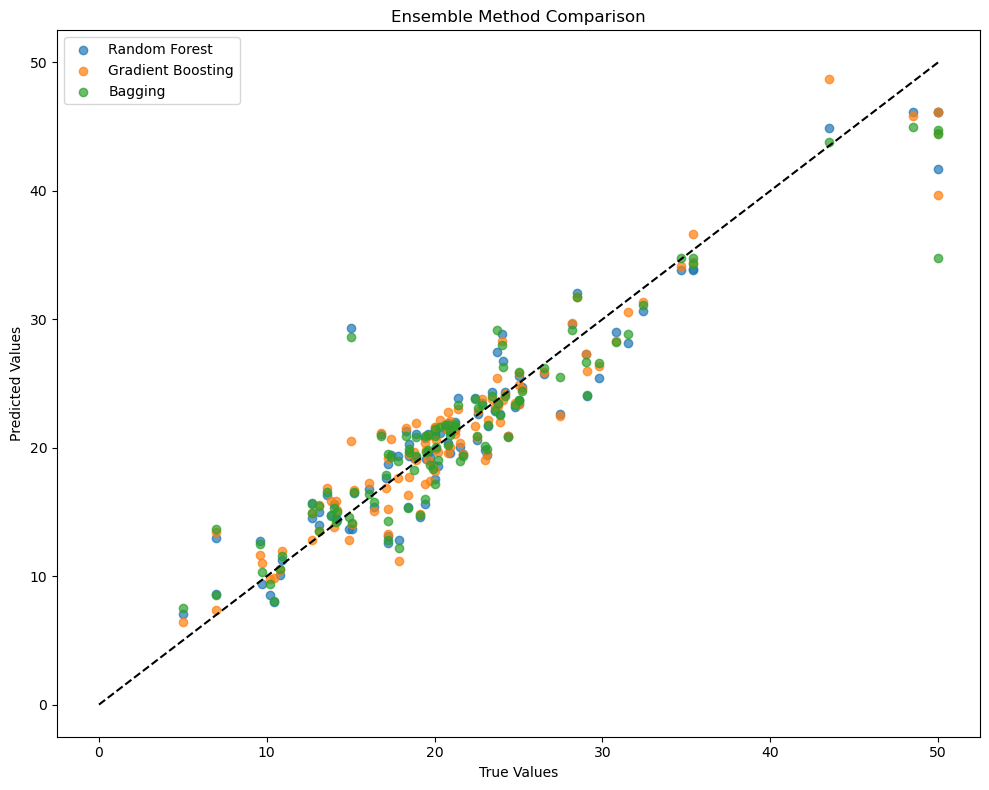

In [282]:
plt.figure(figsize=(10, 8))
for (name, _), y_pred in zip(best_estimators, y_predicted):
    plt.scatter(y_test, y_pred, label=name, alpha=0.7)

plt.plot([0, 50], [0, 50], linestyle='--', color='black')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Ensemble Method Comparison')
plt.legend()
plt.tight_layout()
plt.show()

Residual Plots

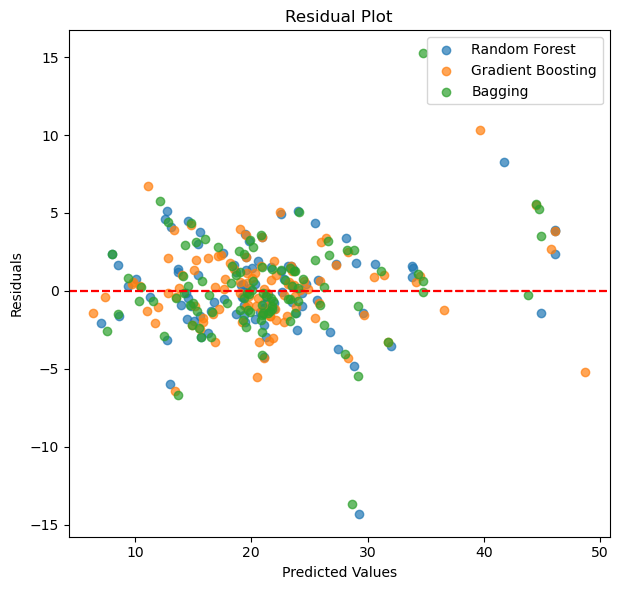

In [283]:
plt.figure(figsize=(18, 6))
for (name, _), y_pred in zip(best_estimators, y_predicted):
    residuals = y_test - y_pred
    
    plt.subplot(1, len(models), i)
    plt.scatter(y_pred, residuals, alpha=0.7, label=name)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f"Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.legend()

plt.tight_layout()
plt.show()